In [1]:
%matplotlib inline

In [2]:
import itertools
import math
import time

import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable

### Load Dataset

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

BATCH_SIZE = 20

import os

from myomniglot import MyOmniglot

setname = 'images_background_small1'

train_dataset = MyOmniglot(root='./data', setname=setname, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)

# train_dataset = dsets.ImageFolder(root='../input/images_background/images_background', transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(105 * 105, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.model(x.view(x.size(0), 105 * 105))
        out = out.view(out.size(0), -1)
        return out

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(BATCH_SIZE, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 105 * 105),
            nn.Tanh()
        )
    
    def forward(self, x):
        
        x = x.view(x.size(0), BATCH_SIZE)
        out = self.model(x)
        return out

### Optimization

### Training

In [6]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images) 
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score

In [7]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels)
    g_loss.backward()
    g_optimizer.step()
    return g_loss

In [8]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 25

In [9]:
import os

dirlist = []

root = './generated/omniglot/python/' + setname

for language in os.listdir(root):
    for character in os.listdir(root + '/' + language):
        characterDir = root + '/' + language + '/' + character
        dirlist.append(characterDir)
    

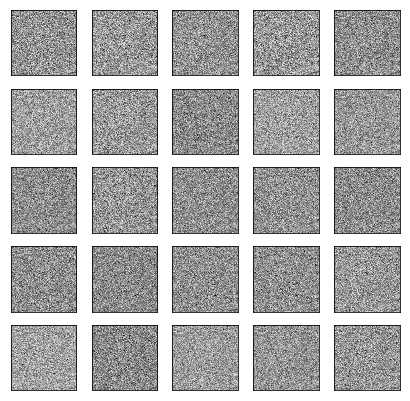

/home/qweenink/.local/lib/python3.5/site-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/601], Step[1/136], d_loss: 1.3738, g_loss: 0.6856, D(x): 0.51, D(G(z)): 0.51
./generated/omniglot/python/images_background_small1/Korean/character01


In [ ]:
import scipy.misc

# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(7, 7))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 601
num_batches = len(train_loader)
num_fig = 0

MINIBATCH_SIZE = 5
lr = 0.0002

for n, (characterSet, _) in enumerate(train_loader):
    saveDir = dirlist[n]
    
    discriminator = Discriminator().cuda()
    generator = Generator().cuda()
    
    criterion = nn.BCELoss()
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    
    plt.imshow(characterSet[0][0].data.cpu().numpy().reshape(105, 105), cmap='Greys')

    for epoch in range(num_epochs):
        idx = torch.randperm(characterSet.size(0))[:MINIBATCH_SIZE]
        images = Variable(characterSet[idx].cuda())
        real_labels = Variable(torch.ones(images.size(0)).cuda())

        # Sample from generator
        noise = Variable(torch.randn(images.size(0), BATCH_SIZE).cuda())
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)

        # Sample again from the generator and get output from discriminator
        noise = Variable(torch.randn(images.size(0), BATCH_SIZE).cuda())
        fake_images = generator(noise)
        outputs = discriminator(fake_images)

        # Train the generator
        g_loss = train_generator(generator, outputs, real_labels)

        if epoch % 100 == 0:
            test_images = generator(Variable(torch.randn(num_test_samples, BATCH_SIZE).cuda()))
            for k in range(num_test_samples):
                i = k//5
                j = k%5
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(105, 105), cmap='Greys')

            display.clear_output(wait=True)
            display.display(plt.gcf())

            #plt.savefig('results/gan-%d.png'%epoch)
            num_fig += 1
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, g_loss: %.4f, ' 
                  'D(x): %.2f, D(G(z)): %.2f' 
                  %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data[0], g_loss.data[0],
                    real_score.data.mean(), fake_score.data.mean()))
            print(saveDir)
            
            
            if epoch != 0 and epoch != 100 and epoch != 200:
                for save in range(5):
                    scipy.misc.toimage(test_images[save].cpu().detach().numpy().reshape(105, 105)).save(saveDir + '/' + 'generated' + str(int(epoch/100)) + '-' + str(save) + '.jpg')
            
            

    #save someimages
fig.close()

In [ ]:
torch.save(generator, 'generator.pt')
torch.save(discriminator, 'discriminator.pt')

In [ ]:
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# set number of epochs and initialize figure counter
num_epochs = 200
num_batches = len(train_loader)
num_fig = 0



for n, (images, labels) in enumerate(train_loader):
    test_images = generator(noise)
    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(105, 105), cmap='Greys')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    break;